In [1]:
 # from model import ToyNet, UNet
from model.utils import timestep_embedding, timesteps_to_tensor
import torch.nn.functional as F

from diffusion import DiffusionProcess
import torch
from diffusion.utils.sde import SDE
import numpy as np
import logging

from pytorch_lightning import LightningDataModule
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib import gridspec
import torch.nn as nn
from torch.distributions import Normal, Categorical, MixtureSameFamily
import torch
#device = 'mps'
device = 'cuda:0'
import random
from src.PCF_with_empirical_measure import PCF_with_empirical_measure

In [2]:
class ResNet_FC(nn.Module):
    def __init__(self, data_dim, hidden_dim, num_res_blocks):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.map=nn.Linear(data_dim, hidden_dim)
        self.res_blocks = nn.ModuleList(
            [self.build_res_block() for _ in range(num_res_blocks)])

    def build_linear(self, in_features, out_features):
        linear = nn.Linear(in_features, out_features)
        return linear

    def build_res_block(self):
        hid = self.hidden_dim
        layers = []
        widths =[hid]*4
        for i in range(len(widths) - 1):
            layers.append(self.build_linear(widths[i], widths[i + 1]))
            layers.append(nn.SiLU())
        return nn.Sequential(*layers)

    def forward(self, x):
        h=self.map(x)
        for res_block in self.res_blocks:
            h = (h + res_block(h)) / np.sqrt(2)
        return h

In [3]:
class ToyNet(nn.Module):
    def __init__(self, data_dim, direction=None):
        super(ToyNet, self).__init__()
        self.direction = direction

        self.time_embed_dim = 128
        dim = 256
        out_dim = data_dim

        self.t_module = nn.Sequential(nn.Linear(self.time_embed_dim, dim), nn.SiLU(), nn.Linear(dim, dim),)
        self.x_module = ResNet_FC(data_dim, dim, num_res_blocks=1)
        self.out_module = nn.Sequential(nn.Linear(dim,dim), nn.SiLU(), nn.Linear(dim, out_dim),)
        
    def forward(self, x, t: int or list[int]):
        t = timesteps_to_tensor(t, batch_size=x.shape[0]).to(x.device)
        t_emb = timestep_embedding(t, self.time_embed_dim)

        t_out = self.t_module(t_emb)
        x_out = self.x_module(x)
        out   = self.out_module(x_out+t_out)

        return out

In [4]:
# Data distribution
mix = Categorical(torch.ones(2,))
comp = Normal(torch.tensor([0 - 2., 0 + 2.]), torch.tensor([.5, .5]))
#comp = Normal(torch.tensor([0 - 2/3., 0 + 2/3.]), torch.tensor([.5/3, .5/3]))
data_dist = MixtureSameFamily(mix, comp)


In [5]:
class SDEProcess(DiffusionProcess):
    def __init__(self, sde_type="VP",
                 sde_info={"VP": {"beta_min": 0.1, "beta_max": 20},
                           "subVP": {"beta_min": 0.1, "beta_max": 20},
                           "VE": {"sigma_min": 0.01, "sigma_max": 50}}, 
                 **kwargs):
        super(SDEProcess, self).__init__(**kwargs)
        assert self.discrete is False, "DDPM is only for continuous data"
        self.dt = 1. / self.total_steps # step size
        self.sde = SDE(self.total_steps, sde_type, sde_info)
        
    def forward_one_step(self, x_prev, t):
        """
        Discretized forward SDE process for actual compuatation: 
        x_{t+1} = x_t + f_t(x_t) * dt + G_t * z_t * sqrt(dt)
        """
        f_t, g_t = self.sde.drifts(x_prev, t-1)
        z = torch.randn_like(x_prev)
        x_t = x_prev + f_t * self.dt + g_t * z * np.sqrt(self.dt)
        return x_t

    
    def backward_one_step(self, x_t, t, pred_score, clip_denoised=True):
        """
        Discretized backward SDE process for actual compuatation:
        x_{t-1} = x_t - (f_t(x_t) - (G_t)^2 * pred_score) * dt + G_t * z_t * sqrt(dt)
        """
        z = torch.randn_like(x_t).to(device)
        f_t, g_t = self.sde.drifts(x_t, t)
        f_t = f_t.to(device)
        x_prev = x_t - (f_t - g_t**2 * pred_score) * self.dt + g_t * z * np.sqrt(self.dt)
        if clip_denoised and x_t.ndim > 2:
            print('backward_one_step')
            x_prev.clamp_(-1., 1.)

        return x_prev

    @torch.no_grad()
    def sample(self, noise, net):
        """
        Sample from backward diffusion process
        """
        x_t = noise
        trajs = [x_t]

        for t in reversed(range(1, self.total_steps+1)):
            pred_score = net(x_t, t)
            x_t = self.backward_one_step(x_t, t, pred_score)
            trajs.append(x_t)
        return x_t, torch.hstack(trajs)
    
    def forward_sample(self, data):
        trajs = torch.zeros([len(data), self.total_steps+1])
        x = data.to(device)
        trajs[:, 0] = x
        for t in range(1, self.total_steps+1):
            x = self.forward_one_step(x, t)
            trajs[:, t] = x
        return x, trajs
    
    def backward_sample(self, noise, net):
        """
        Sample from backward diffusion process
        """
        x_t = noise
        trajs = [x_t]

        for t in reversed(range(1, self.total_steps+1)):
            pred_score = net(x_t, t)
            x_t = self.backward_one_step(x_t, t, pred_score)
            trajs.append(x_t)
        return x_t, torch.hstack(trajs)


In [6]:
score_net = ToyNet(data_dim=1).to(device)
total_steps = 100
num_paths = 32
diffusion = SDEProcess(discrete=False, total_steps=total_steps, sde_type="VP")

In [7]:
x_gen, traj_back = diffusion.sample(torch.randn([num_paths, 1]).to(device), score_net)


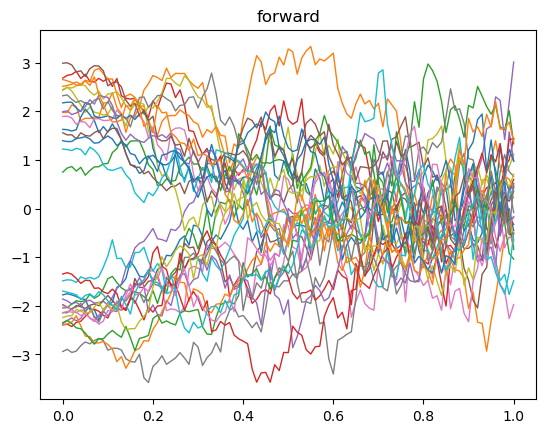

In [8]:
x_data_test = data_dist.sample([num_paths])
x_noise_test, traj_forward_test = diffusion.forward_sample(x_data_test)

xxx = np.linspace(0, 1, traj_forward_test.shape[1])
for line in traj_forward_test:
    plt.plot(xxx, line, linewidth=1.0)
    plt.title('forward')

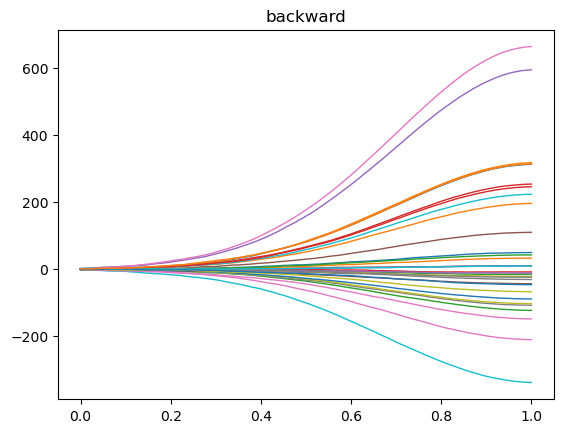

In [9]:
x_gen, traj_back = diffusion.sample(torch.randn([num_paths, 1]).to(device), score_net)
xxx = np.linspace(0, 1, traj_forward_test.shape[1])
for line in traj_back:
    plt.plot(xxx, line.cpu(), linewidth=1.0)
    plt.title('backward')

Train the network with PCF distance and reconstrucion loss. 

I haven't add time dimension to the input so far in this implementation bacause it doesn't work well now. If anyone wants to add time dimension, just replace pcf = PCF_with_empirical_measure(16, 12, 1) with pcf = PCF_with_empirical_measure(16, 12, 1, add_time=True) in belowing code cell.

Current implementation is not stable. Sometimes you may not get the backward figure as I show below. In this case, training extra 50 or 100 epoches may bring the similar result.  Anyway, I will keep working on it. 

In [22]:
def loss_function(x0, diffusion_process, score_net, t):
    #f_t is not involved in the score matching loss soe input zeros for the 1st argument.
    #
    _, g_t = diffusion_process.sde.drifts(torch.zeros_like(x0), t)
    
    # Eq 29 in Score based diffusion model (Yang Song 2021 ICLR)
    mean, std = diffusion_process.sde.perturbation_kernel(x0, t)
    z = torch.randn_like(x0)

    x_t = mean + std * z  # x_t is perturbed x_0
    pred_score = score_net(x_t, t)
    target = -z / std   # Since desired derivative of the given kernel is - (x_t - mean) / std^2
    loss = g_t**2 * F.mse_loss(pred_score, target, reduction="sum") / np.prod(x0.size())
    return loss

In [ ]:
x_data = data_dist.sample([num_paths]).to(device)
x_noise, traj_forward = diffusion.forward_sample(x_data)

# SDE-based diffusion models

In [23]:
num_epochs = 250
opt = torch.optim.Adam(score_net.parameters(), lr=1e-3)

for i in range(num_epochs):
    # Forward process to generate time series
    opt.zero_grad()
    x0 = data_dist.sample([num_paths]).to(device)
    t = np.random.randint(1, total_steps + 1)
    loss = loss_function(x0.view(-1 ,1), diffusion, score_net, t)
    loss.backward()
    opt.step()
    if(i%50==0):
        print(i, loss)

0 tensor(8.7113, device='cuda:0', grad_fn=<DivBackward0>)
50 tensor(1.9116, device='cuda:0', grad_fn=<DivBackward0>)
100 tensor(0.0498, device='cuda:0', grad_fn=<DivBackward0>)
150 tensor(4.0772, device='cuda:0', grad_fn=<DivBackward0>)
200 tensor(0.1983, device='cuda:0', grad_fn=<DivBackward0>)


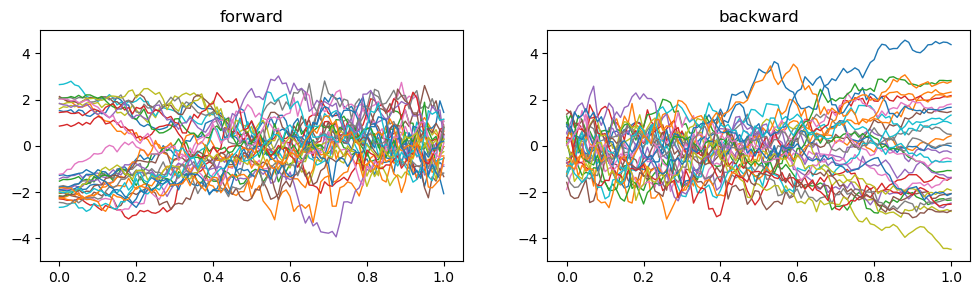

In [24]:
xxx = np.linspace(0, 1, traj_forward.shape[1])

plt.figure(figsize=(12,3))

plt.subplot(1, 2, 1)
for line in traj_forward:
    plt.plot(xxx, line.cpu(), linewidth=1.0)
    plt.title('forward')
plt.ylim(-5, 5)
    
plt.subplot(1, 2, 2)
x_gen, traj_back = diffusion.sample(torch.randn([num_paths, 1]).to(device), score_net)


for line in traj_back:
    plt.plot(xxx, line.cpu(), linewidth=1.0)
    plt.title('backward')
plt.ylim(-5, 5)

plt.show()

# Reconstruction-loss based diffusion models

In [25]:
from src.PCF_with_empirical_measure import PCF_with_empirical_measure

pcf = PCF_with_empirical_measure(30, 12, 1)
pcf = pcf.to(device)

num_epochs = 200
opt = torch.optim.Adam(score_net.parameters(), lr=1e-3)

for i in range(num_epochs):

    opt.zero_grad()
    x_data = data_dist.sample([num_paths])
    x_noise, traj_forward = diffusion.forward_sample(x_data)
    traj_forward = traj_forward.to(device)
    # Backward process to generate time series
    x_data1 = data_dist.sample([num_paths])
    x_noise1, traj_forward1 = diffusion.forward_sample(x_data1)
    
    x_gen, traj_back = diffusion.backward_sample(torch.randn([num_paths, 1]).to(device), score_net)
    x_gen1, traj_back1 = diffusion.backward_sample(traj_forward[:,-1].unsqueeze(1).to(device), score_net) 
    traj_back_flip = torch.fliplr(traj_back)
    traj_back_flip1 = torch.fliplr(traj_back1)
    loss = (pcf.distance_measure(traj_forward.view([-1, total_steps+1, 1]), traj_back_flip.view([-1, total_steps+1, 1]), Lambda=1.0)
                        + torch.mean(((traj_forward - traj_back_flip1)**2).reshape(traj_back.shape[0], -1), dim=(0,1)))
    loss.backward()
    opt.step()
    print(i, loss)

0 tensor(7.6003, device='cuda:0', grad_fn=<AddBackward0>)
1 tensor(5.9694, device='cuda:0', grad_fn=<AddBackward0>)
2 tensor(5.7365, device='cuda:0', grad_fn=<AddBackward0>)
3 tensor(6.7057, device='cuda:0', grad_fn=<AddBackward0>)
4 tensor(7.1998, device='cuda:0', grad_fn=<AddBackward0>)
5 tensor(6.4496, device='cuda:0', grad_fn=<AddBackward0>)
6 tensor(6.3981, device='cuda:0', grad_fn=<AddBackward0>)
7 tensor(4.8068, device='cuda:0', grad_fn=<AddBackward0>)
8 tensor(6.1216, device='cuda:0', grad_fn=<AddBackward0>)
9 tensor(4.3482, device='cuda:0', grad_fn=<AddBackward0>)
10 tensor(5.6960, device='cuda:0', grad_fn=<AddBackward0>)
11 tensor(4.8598, device='cuda:0', grad_fn=<AddBackward0>)
12 tensor(4.4039, device='cuda:0', grad_fn=<AddBackward0>)
13 tensor(5.5425, device='cuda:0', grad_fn=<AddBackward0>)
14 tensor(4.6219, device='cuda:0', grad_fn=<AddBackward0>)
15 tensor(6.5141, device='cuda:0', grad_fn=<AddBackward0>)
16 tensor(4.0806, device='cuda:0', grad_fn=<AddBackward0>)
17 tens

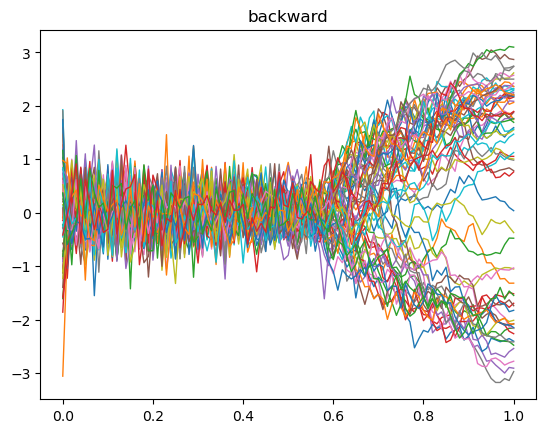

In [27]:
x_gen, traj_back = diffusion.sample(torch.randn([num_paths, 1]).cuda(), score_net)
xxx = np.linspace(0, 1, traj_forward.shape[1])
for line in traj_back:
    plt.plot(xxx, line.cpu(), linewidth=1.0)
    plt.title('backward')

Train the model only using reconstruction loss. It doesn't give a good result. Can find a better loss to replace reconstrcton loss. After I find a better loss, combining PCF loss with another better loss should bring better and more stable results. 

In [ ]:
num_epochs = 200
opt = torch.optim.Adam(score_net.parameters(), lr=1e-3)
for i in range(num_epochs):
    # Forward process to generate time series
    opt.zero_grad()
    x_data = data_dist.sample([num_paths])
    x_noise, traj_forward = diffusion.forward_sample(x_data)
    traj_forward = traj_forward.to(device)
    # Backward process to generate time series
    x_gen1, traj_back1 = diffusion.backward_sample(traj_forward[:,-1].unsqueeze(1).to(device), score_net) 
    traj_back_flip1 = torch.fliplr(traj_back1)
    loss = (torch.mean(((traj_forward - traj_back_flip1)**2).reshape(traj_back_flip1.shape[0], -1), dim=(0,1)))
    loss.backward()
    opt.step()
    print(i, loss)

In [ ]:
x_gen, traj_back = diffusion.sample(torch.randn([num_paths, 1]).cuda(), score_net)
xxx = np.linspace(0, 1, traj_forward.shape[1])
for line in traj_back:
    plt.plot(xxx, line.cpu(), linewidth=1.0)
    plt.title('backward')

In [ ]:
x_gen, traj_back = diffusion.sample(torch.randn([num_paths, 1]).cuda(), score_net)
xxx = np.linspace(0, 1, traj_forward.shape[1])
for line in traj_back:
    plt.plot(xxx, line.cpu(), linewidth=1.0)
    plt.title('backward')

Train the model only using PCF loss. 

(So far I don't get a good result after adding time dimension.) 



In [ ]:
pcf = PCF_with_empirical_measure(16, 12, 1, add_time= True)
pcf = pcf.to(device)
num_epochs = 100
for i in range(num_epochs):
    if i>500:
        G_opt = torch.optim.Adam(score_net.parameters(), lr=5e-4)
        D_opt = torch.optim.Adam(pcf.parameters(), lr=5e-4)
    elif i>800:
        G_opt = torch.optim.Adam(score_net.parameters(), lr=1e-4)
        D_opt = torch.optim.Adam(pcf.parameters(), lr=1e-4)
    x_data = data_dist.sample([num_paths])
    x_noise, traj_forward = diffusion.forward_sample(x_data)
    traj_forward = traj_forward.to(device)
        
    
    # train the PCF network as a discriminator. We want PCF has a great ablitily to distinguish the real data and the generated data. 
    # So we train the PCF to maxmise the distance between the real data and the generated data.
    with torch.no_grad():
        x_gen, traj_back = diffusion.backward_sample(torch.cat((torch.randn([num_paths, 1]).to(device), traj_forward[:,-1].unsqueeze(1)),0), score_net)
        traj_forward_flip = torch.fliplr(traj_forward)
        traj_forward_flip_cat = torch.cat((traj_forward_flip.view([-1, total_steps+1, 1]),traj_forward_flip.view([-1, total_steps+1, 1])),0)

    pcf.train()
    D_loss = -pcf.distance_measure(traj_forward_flip_cat, traj_back.view([-1, total_steps+1, 1]), Lambda=1.0)

    D_opt.zero_grad()
    D_loss.backward()
    D_opt.step()
   
    # train the score network to minmise the distance between the real data and the generated data
    x_gen, traj_back = diffusion.backward_sample(torch.cat((torch.randn([num_paths, 1]).to(device), traj_forward[:,-1].unsqueeze(1)),0).to(device), score_net)
    x_gen1, traj_back1 = x_gen[num_paths:], traj_back[num_paths:]
    traj_back_flip1 = torch.fliplr(traj_back1)
    pcf.eval()
    
    G_loss =  pcf.distance_measure(traj_forward_flip_cat, traj_back.view([-1, total_steps+1, 1]), Lambda=1.0) + \
        0.5*torch.mean(((traj_forward - traj_back_flip1)**2).reshape(traj_forward.shape[0], -1), dim=(0,1))

    G_opt.zero_grad()
    G_loss.backward()
    G_opt.step()

    print(i, D_loss.item() , G_loss.item())

In [ ]:
pcf = PCF_with_empirical_measure(16, 12, 1, add_time=True)
pcf = pcf.to(device)

num_epochs = 1
opt = torch.optim.Adam(score_net.parameters(), lr=1e-3)
for i in range(num_epochs):
    # Forward process to generate time series
    opt.zero_grad()
    x_data = data_dist.sample([num_paths])
    x_noise, traj_forward = diffusion.forward_sample(x_data)
    traj_forward = traj_forward.to(device)
    # Backward process to generate time series
    x_gen, traj_back = diffusion.backward_sample(torch.randn([num_paths, 1]).to(device), score_net)
    traj_back_flip = torch.fliplr(traj_back)
    traj_forward_flip = torch.fliplr(traj_forward)
    loss = pcf.distance_measure(traj_forward_flip.view([-1, total_steps+1, 1]), 
                                traj_back.view([-1, total_steps+1, 1]), Lambda=0.01) 

    loss.backward()
    opt.step()
    print(i, loss)

In [ ]:
x_gen, traj_back = diffusion.sample(torch.randn([50, 1]).cuda(), score_net)
xxx = np.linspace(0, 1, traj_forward.shape[1])
for line in traj_back:
    plt.plot(xxx, line.cpu(), linewidth=1.0)
    plt.title('backward')

In [ ]:
x_gen, traj_back = diffusion.sample(torch.randn([500, 1]).cuda(), score_net)
plt.hist(x_gen[:, 0].cpu(), bins = 50, density=True)


In [ ]:
plt.hist(x_data_test.cpu(), bins = 50, density=True)

In [ ]:
x_gen[0]

In [ ]:
print(x_gen[:, 0])

In [ ]:
print(pcf.parameters())

In [ ]:
print(traj_forward.shape)
print(traj_back.shape)

In [ ]:
print(traj_forward_flip[:, [0, 101]].view([-1, 2, 1]).shape)

In [ ]:
def mask_time(a):
    b = a[::2, :]
    return b

a = torch.randn([100, 1])
b = mask_time(a)
print(a)
print(b)
              

# PCFD only distance

In [28]:
pcf = PCF_with_empirical_measure(16, 10, 1, add_time=True)
pcf = pcf.to(device)
num_paths = 64
G_opt = torch.optim.Adam(score_net.parameters(), lr=1e-4, betas=(0.9, 0.999))
D_opt = torch.optim.Adam(pcf.parameters(), lr=5e-3, betas=(0.9, 0.999))
n_Gstep_per_Dstep = 20
num_epochs = 50
for i in range(num_epochs):
    x_data = data_dist.sample([num_paths])
    x_noise, traj_forward = diffusion.forward_sample(x_data)
    traj_forward = traj_forward.to(device)
    traj_forward_flip = torch.fliplr(traj_forward)
             
    # train the PCF network as a discriminator. We want PCF has a great ablitily to distinguish the real data and the generated data. 
    # So we train the PCF to maxmise the distance between the real data and the generated data.
    with torch.no_grad():
        x_gen, traj_back = diffusion.backward_sample(torch.randn([num_paths, 1]).to(device), score_net)
        
        
    pcf.train()
    D_loss = -pcf.distance_measure(traj_forward_flip.view([-1, total_steps+1, 1]), 
                                traj_back.view([-1, total_steps+1, 1]), Lambda=0.0) 

    D_opt.zero_grad()
    D_loss.backward()
    D_opt.step()
    pcf.eval()

    for j in range(n_Gstep_per_Dstep):
        with torch.no_grad():
            x_data = data_dist.sample([num_paths])
            x_noise, traj_forward = diffusion.forward_sample(x_data)
            traj_forward = traj_forward.to(device)
            x_gen, traj_back = diffusion.backward_sample(torch.randn([num_paths, 1]).to(device), score_net) 
        traj_forward_flip = torch.fliplr(traj_forward)
        G_loss =  pcf.distance_measure(traj_forward_flip.view([-1, total_steps+1, 1]), 
                                traj_back.view([-1, total_steps+1, 1]), Lambda=0) 
        G_opt.zero_grad()
        G_loss.backward()
        G_opt.step()
        pcf.eval()
        print(j, G_loss.item())
    
    print(i, D_loss.item(), G_loss.item())

0 1.24203622341156
1 0.9093620181083679
2 1.1079565286636353
3 1.2330095767974854
4 1.2853211164474487
5 1.691382884979248
6 1.2660586833953857
7 1.0176109075546265
8 1.1389565467834473
9 1.1665332317352295
10 1.1704678535461426
11 1.1747612953186035
12 1.4950611591339111
13 1.0437366962432861
14 1.5920007228851318
15 1.505130648612976
16 1.2358732223510742
17 1.252066731452942
18 1.0515952110290527
19 1.2246618270874023
0 -1.2438766956329346 1.2246618270874023
0 1.102679967880249
1 1.3151073455810547
2 1.146126627922058
3 1.1990442276000977
4 1.3462388515472412
5 1.3605599403381348
6 1.1942485570907593
7 1.15194833278656
8 1.3049883842468262
9 1.0694429874420166
10 1.7729837894439697
11 1.5793784856796265
12 1.227073311805725
13 1.2305444478988647
14 1.3409254550933838
15 1.2743709087371826
16 1.4070584774017334
17 1.324617862701416
18 1.36100172996521
19 1.0595712661743164
1 -1.3964674472808838 1.0595712661743164
0 1.4687069654464722
1 1.209301471710205
2 1.504561185836792
3 1.107493

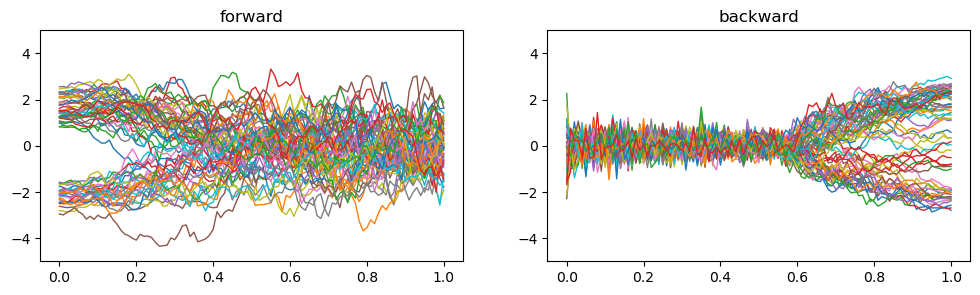

In [29]:
xxx = np.linspace(0, 1, traj_forward.shape[1])

plt.figure(figsize=(12,3))

plt.subplot(1, 2, 1)
for line in traj_forward:
    plt.plot(xxx, line.cpu(), linewidth=1.0)
    plt.title('forward')
plt.ylim(-5, 5)
    
plt.subplot(1, 2, 2)
x_gen, traj_back = diffusion.sample(torch.randn([num_paths, 1]).to(device), score_net)


for line in traj_back:
    plt.plot(xxx, line.cpu(), linewidth=1.0)
    plt.title('backward')
plt.ylim(-5, 5)

plt.show()

In [ ]:
plt.hist(x_gen[:, -1].cpu(), bins = 50, density=True)

In [ ]:
x_data_test = data_dist.sample([1000])
x_noise_test, traj_forward_test = diffusion.forward_sample(x_data_test)
plt.hist(x_noise_test.cpu(), bins = 100, density=True)
y_noise = traj_back[:, 0]
plt.hist(y_noise.cpu(), bins = 100, density=True)

In [ ]:
x_noise, traj_forward = diffusion.forward_sample(x_data)
traj_forward = traj_forward.to(device)
plt.hist(traj_forward[:, -1].cpu(), bin = 10,density = True) 
print(traj_forward_flip.shape)

# add the lead-lag transformation

In [30]:
def lead_lag_transform(x: torch.Tensor) -> torch.Tensor:
    """
    Lead-lag transformation for a multivariate paths.
    """
    x_rep = torch.repeat_interleave(x, repeats=2, dim=1)
    #print(x_rep.shape)
    x_ll = torch.cat([x_rep[:,  :-1], x_rep[:, 1:]], dim=2)
   # print(x_ll.shape)
    return x_ll


In [31]:
"""
Simple augmentations to enhance the capability of capturing important features in the first components of the
signature.
"""
from dataclasses import dataclass
from typing import List, Tuple

@dataclass
class BaseAugmentation:
    pass

    def apply(self, *args: List[torch.Tensor]) -> torch.Tensor:
        raise NotImplementedError('Needs to be implemented by child.')

@dataclass
class LeadLag(BaseAugmentation):
    with_time: bool = False

    def apply(self, x: torch.Tensor):
        if self.with_time:
            return lead_lag_transform_with_time(x)
        else:
            return lead_lag_transform(x)

def apply_augmentations(x: torch.Tensor, augmentations: Tuple) -> torch.Tensor:
    y = x.clone()
    for augmentation in augmentations:
        y = augmentation.apply(y)
    return y


In [32]:
ll = LeadLag()
t = traj_forward.view([-1, total_steps+1, 1])
a = ll.apply(t)

In [33]:
pcf1 = PCF_with_empirical_measure(16, 10, 2, add_time=True)
pcf1 = pcf1.to(device)
num_paths = 32
G_opt = torch.optim.Adam(score_net.parameters(), lr=1e-4)
D_opt = torch.optim.Adam(pcf.parameters(), lr=5e-3, betas=(0.9, 0.999))
n_Gstep_per_Dstep = 10
num_epochs = 5
for i in range(num_epochs):
    x_data = data_dist.sample([num_paths])
    x_noise, traj_forward = diffusion.forward_sample(x_data)
    traj_forward = traj_forward.to(device)
    traj_forward_flip = torch.fliplr(traj_forward)
             
    # train the PCF network as a discriminator. We want PCF has a great ablitily to distinguish the real data and the generated data. 
    # So we train the PCF to maxmise the distance between the real data and the generated data.
    with torch.no_grad():
        x_gen, traj_back = diffusion.backward_sample(torch.randn([num_paths, 1]).to(device), score_net)
            
    pcf1.train()
    D_loss = -pcf1.distance_measure(ll.apply(traj_forward_flip.view([-1, total_steps+1, 1])), ll.apply(traj_back.view([-1, total_steps+1, 1])), Lambda=0.0)
 

    D_opt.zero_grad()
    D_loss.backward()
    D_opt.step()
    pcf1.eval()

    for j in range(n_Gstep_per_Dstep):
        with torch.no_grad():
            x_data = data_dist.sample([num_paths])
            x_noise, traj_forward = diffusion.forward_sample(x_data)
            traj_forward = traj_forward.to(device)
            x_gen, traj_back = diffusion.backward_sample(torch.randn([num_paths, 1]).to(device), score_net) 
        traj_forward_flip = torch.fliplr(traj_forward)
        G_loss =  pcf1.distance_measure(ll.apply(traj_forward_flip.view([-1, total_steps+1, 1])), 
                                ll.apply(traj_back.view([-1, total_steps+1, 1])), Lambda=0) 
        G_opt.zero_grad()
        G_loss.backward()
        G_opt.step()
        pcf1.eval()
        print(j, G_loss.item())
    
    print(i, D_loss.item(), G_loss.item())

0 0.6283206939697266
1 0.6162539720535278
2 0.6386005282402039
3 0.627577006816864
4 0.6519114971160889
5 0.6362988948822021
6 0.6333223581314087
7 0.6379176378250122
8 0.6560930609703064
9 0.6115647554397583
0 -0.6448259353637695 0.6115647554397583
0 0.6524150371551514
1 0.6387256383895874
2 0.619739294052124
3 0.6120383739471436
4 0.6327090263366699
5 0.6351760625839233
6 0.6315304040908813
7 0.6157016754150391
8 0.64493328332901
9 0.6177793741226196
1 -0.6300123929977417 0.6177793741226196
0 0.6521701812744141
1 0.6184980869293213
2 0.5930813550949097
3 0.6161400079727173
4 0.6325019598007202
5 0.6402747631072998
6 0.6229607462882996
7 0.635688066482544
8 0.6380850076675415
9 0.612099289894104
2 -0.611086905002594 0.612099289894104
0 0.6129793524742126
1 0.630795419216156
2 0.658671498298645
3 0.6022896766662598
4 0.6381551623344421
5 0.6199939846992493
6 0.6380935311317444
7 0.6148618459701538
8 0.6132954359054565
9 0.6357632279396057
3 -0.6365100741386414 0.6357632279396057
0 0.62

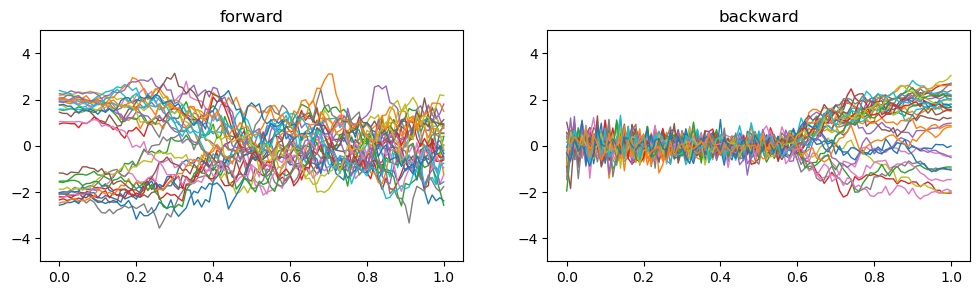

In [35]:
xxx = np.linspace(0, 1, traj_forward.shape[1])

plt.figure(figsize=(12,3))

plt.subplot(1, 2, 1)
for line in traj_forward:
    plt.plot(xxx, line.cpu(), linewidth=1.0)
    plt.title('forward')
plt.ylim(-5, 5)
    
plt.subplot(1, 2, 2)
x_gen, traj_back = diffusion.sample(torch.randn([num_paths, 1]).to(device), score_net)


for line in traj_back:
    plt.plot(xxx, line.cpu(), linewidth=1.0)
    plt.title('backward')
plt.ylim(-5, 5)

plt.show()